In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

random.seed(42) # начальное состояние генератора случайных чисел, чтобы можно было воспроизводить результаты.

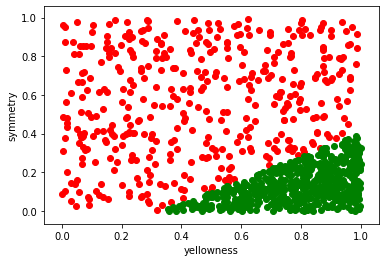

In [2]:
%matplotlib inline
data = np.loadtxt("data.csv", delimiter=",")
pears = data[:, 2] == 1
apples = np.logical_not(pears)
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
plt.show()

In [3]:
class Perceptron:

    def __init__(self, w, b):
        """
        Инициализируем наш объект - перцептрон.
        w - вектор весов размера (m, 1), где m - количество переменных
        b - число
        """
        
        self.w = w
        self.b = b

    def forward_pass(self, single_input):
        """
        Метод рассчитывает ответ перцептрона при предъявлении одного примера
        single_input - вектор примера размера (m, 1).
        Метод возвращает число (0 или 1) или boolean (True/False)
        """
        
        result = 0
        for i in range(0, len(self.w)):
            result += self.w[i] * single_input[i]
        result += self.b
        
        if result > 0:
            return 1
        else:
            return 0

    def vectorized_forward_pass(self, input_matrix):
        """
        Метод рассчитывает ответ перцептрона при предъявлении набора примеров
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных
        Возвращает вертикальный вектор размера (n, 1) с ответами перцептрона
        (элементы вектора - boolean или целые числа (0 или 1))
        """
        return (input_matrix.dot(self.w) > -self.b)
    
    def train_on_single_example(self, example, y):
        """
        принимает вектор активации входов example формы (m, 1) 
        и правильный ответ для него (число 0 или 1 или boolean),
        обновляет значения весов перцептрона в соответствии с этим примером
        и возвращает размер ошибки, которая случилась на этом примере до изменения весов (0 или 1)
        (на её основании мы потом построим интересный график)
        """
        diff = y - self.vectorized_forward_pass(example.T)
        self.w += example * diff
        self.b += diff
        return (diff)

    def train_until_convergence(self, input_matrix, y, max_steps=1e8):
        """
        input_matrix - матрица входов размера (n, m),
        y - вектор правильных ответов размера (n, 1) (y[i] - правильный ответ на пример input_matrix[i]),
        max_steps - максимальное количество шагов.
        Применяем train_on_single_example, пока не перестанем ошибаться или до умопомрачения.
        Константа max_steps - наше понимание того, что считать умопомрачением.
        """
        i = 0
        errors = 1
        while errors and i < max_steps:
            i += 1
            errors = 0
            for example, answer in zip(input_matrix, y):
                example = example.reshape((example.size, 1))
                error = self.train_on_single_example(example, answer)
                errors += int(error)

In [4]:

def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

In [5]:
class Neuron:
    
    def __init__(self, weights, activation_function=sigmoid, activation_function_derivative=sigmoid_prime):
        """
        weights - вертикальный вектор весов нейрона формы (m, 1), weights[0][0] - смещение
        activation_function - активационная функция нейрона, сигмоидальная функция по умолчанию
        activation_function_derivative - производная активационной функции нейрона
        """
        
        assert weights.shape[1] == 1, "Incorrect weight shape"
        
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        
    def forward_pass(self, single_input):
        """
        активационная функция логистического нейрона
        single_input - вектор входов формы (m, 1), 
        первый элемент вектора single_input - единица (если вы хотите учитывать смещение)
        """
        
        result = 0
        for i in range(self.w.size):
            result += float(self.w[i] * single_input[i])
        return self.activation_function(result)
    
    def summatory(self, input_matrix):
        """
        Вычисляет результат сумматорной функции для каждого примера из input_matrix. 
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вектор значений сумматорной функции размера (n, 1).
        """
        return(input_matrix.dot(self.w))
        
    
    def activation(self, summatory_activation):
        """
        Вычисляет для каждого примера результат активационной функции,
        получив на вход вектор значений сумматорной функций
        summatory_activation - вектор размера (n, 1), 
        где summatory_activation[i] - значение суммматорной функции для i-го примера.
        Возвращает вектор размера (n, 1), содержащий в i-й строке 
        значение активационной функции для i-го примера.
        """
        return(self.activation_function(summatory_activation))
    
    def vectorized_forward_pass(self, input_matrix):
        """
        Векторизованная активационная функция логистического нейрона.
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вертикальный вектор размера (n, 1) с выходными активациями нейрона
        (элементы вектора - float)
        """
        return self.activation(self.summatory(input_matrix))
        
    def SGD(self, X, y, batch_size, learning_rate=0.1, eps=1e-6, max_steps=200):
        """
        Внешний цикл алгоритма градиентного спуска.
        X - матрица входных активаций (n, m)
        y - вектор правильных ответов (n, 1)
        
        learning_rate - константа скорости обучения
        batch_size - размер батча, на основании которого 
        рассчитывается градиент и совершается один шаг алгоритма
        
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        Вторым вариантом была бы проверка размера градиента, а не изменение функции,
        что будет работать лучше - неочевидно. В заданиях используйте первый подход.
        
        max_steps - критерий остановки номер два: если количество обновлений весов 
        достигло max_steps, то алгоритм останавливается
        
        Метод возвращает 1, если отработал первый критерий остановки (спуск сошёлся) 
        и 0, если второй (спуск не достиг минимума за отведённое время).
        """
        
        args = np.arange(X.shape[0])
        for i in range(max_steps):
            batch = np.random.choice(args, batch_size, replace=False)
            if (self.update_mini_batch(X[batch], y[batch],learning_rate, eps)):
                return (1)                                    
        return (0)
    
    def update_mini_batch(self, X, y, learning_rate, eps):
        """
        X - матрица размера (batch_size, m)
        y - вектор правильных ответов размера (batch_size, 1)
        learning_rate - константа скорости обучения
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        
        Рассчитывает градиент (не забывайте использовать подготовленные заранее внешние функции) 
        и обновляет веса нейрона. Если ошибка изменилась меньше, чем на eps - возвращаем 1, 
        иначе возвращаем 0.
        """
        J_before = J_quadratic(self, X, y)
        self.w -= learning_rate * compute_grad_analytically(self, X, y)
        return abs(J_quadratic(self, X, y) - J_before) < eps

In [6]:
def J_quadratic(neuron, X, y):
    """
    Оценивает значение квадратичной целевой функции.
    Всё как в лекции, никаких хитростей.

    neuron - нейрон, у которого есть метод vectorized_forward_pass, предсказывающий значения на выборке X
    X - матрица входных активаций (n, m)
    y - вектор правильных ответов (n, 1)
        
    Возвращает значение J (число)
    """
    
    assert y.shape[1] == 1, 'Incorrect y shape'
    
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    """
    Вычисляет вектор частных производных целевой функции по каждому из предсказаний.
    y_hat - вертикальный вектор предсказаний,
    y - вертикальный вектор правильных ответов,
    
    В данном случае функция смехотворно простая, но если мы захотим поэкспериментировать 
    с целевыми функциями - полезно вынести эти вычисления в отдельный этап.
    
    Возвращает вектор значений производной целевой функции для каждого примера отдельно.
    """
    
    assert y_hat.shape == y.shape and y_hat.shape[1] == 1, 'Incorrect shapes'
    
    return (y_hat - y) / len(y)
    
def compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative):
    """
    Аналитическая производная целевой функции
    neuron - объект класса Neuron
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений
    y - правильные ответы для примеров из матрицы X
    J_prime - функция, считающая производные целевой функции по ответам
    
    Возвращает вектор размера (m, 1)
    """
    
    # Вычисляем активации
    # z - вектор результатов сумматорной функции нейрона на разных примерах
    
    z = neuron.summatory(X)
    y_hat = neuron.activation(z)

    # Вычисляем нужные нам частные производные
    dy_dyhat = J_prime(y, y_hat)
    dyhat_dz = neuron.activation_function_derivative(z)
    
    # осознайте эту строчку:
    dz_dw = X

    # а главное, эту:
    grad = ((dy_dyhat * dyhat_dz).T).dot(dz_dw)
    
    # можно было написать в два этапа. Осознайте, почему получается одно и то же
    # grad_matrix = dy_dyhat * dyhat_dz * dz_dw
    # grad = np.sum(, axis=0)
    
    # Сделаем из горизонтального вектора вертикальный
    grad = grad.T
    
    return grad

In [7]:
def compute_grad_numerically_2(neuron, X, y, J=J_quadratic, eps=10e-2):
    """
    Численная производная целевой функции.
    neuron - объект класса Neuron с вертикальным вектором весов w,
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений,
    y - правильные ответы для тестовой выборки X,
    J - целевая функция, градиент которой мы хотим получить,
    eps - размер $\delta w$ (малого изменения весов).
    """
    w_0 = neuron.w
    num_grad = np.zeros(w_0.shape)
    for i in range(len(w_0)):
        old_wi = neuron.w[i].copy()
        neuron.w[i] += eps
        J_plus = J(neuron, X, y)
        neuron.w[i] -= 2*eps
        num_grad[i] = (J_plus - J(neuron, X, y))/2/eps
        neuron.w[i] = old_wi
        
    assert np.allclose(neuron.w, w_0), "МЫ ИСПОРТИЛИ НЕЙРОНУ ВЕСА"
    return num_grad                

In [8]:
def compute_grad_numerically(neuron, X, y, J=J_quadratic, eps=10e-2):
    """
    Численная производная целевой функции
    neuron - объект класса Neuron
    X - вертикальная матрица входов формы (n, m), на которой считается сумма квадратов отклонений
    y - правильные ответы для тестовой выборки X
    J - целевая функция, градиент которой мы хотим получить
    eps - размер $\delta w$ (малого изменения весов)
    """

    initial_cost = J(neuron, X, y)
    w_0 = neuron.w
    num_grad = np.zeros(w_0.shape)
    
    for i in range(len(w_0)):
        
        old_wi = neuron.w[i].copy()
        # Меняем вес
        neuron.w[i] += eps
        
        # Считаем новое значение целевой функции и вычисляем приближенное значение градиента
        num_grad[i] = (J(neuron, X, y) - initial_cost)/eps
        
        # Возвращаем вес обратно. Лучше так, чем -= eps, чтобы не накапливать ошибки округления
        neuron.w[i] = old_wi
            
    # проверим, что не испортили нейрону веса своими манипуляциями
    assert np.allclose(neuron.w, w_0), "МЫ ИСПОРТИЛИ НЕЙРОНУ ВЕСА"
    return num_grad

In [15]:
# Подготовим данные

X = data[:, :-1]
y = data[:, -1]

X = np.hstack((np.ones((len(y), 1)), X))
y = y.reshape((len(y), 1)) # Обратите внимание на эту очень противную и важную строчку


# Создадим нейрон

w = np.random.random((X.shape[1], 1))
neuron = Neuron(w, activation_function=sigmoid, activation_function_derivative=sigmoid_prime)

# Посчитаем пример
num_grad = compute_grad_numerically(neuron, X, y, J=J_quadratic)
an_grad = compute_grad_analytically(neuron, X, y, J_prime=J_quadratic_derivative)

print("Численный градиент: \n", num_grad)
print("Аналитический градиент: \n", an_grad)

Численный градиент: 
 [[-0.00494371]
 [-0.02346341]
 [ 0.02394713]]
Аналитический градиент: 
 [[-0.00788364]
 [-0.02507484]
 [ 0.02360477]]


In [17]:
def J_by_weights(weights, X, y, bias):
    """
    Посчитать значение целевой функции для нейрона с заданными весами.
    Только для визуализации
    """
    new_w = np.hstack((bias, weights)).reshape((3,1))
    return J_quadratic(Neuron(new_w), X, y)

In [37]:
%matplotlib inline

max_b = 40
min_b = -40
max_w1 = 40
min_w1 = -40
max_w2 = 40
min_w2 = -40

g_bias = 0 # график номер 2 будет при первой генерации по умолчанию иметь то значение b, которое выставлено в первом
X_corrupted = X.copy()
y_corrupted = y.copy()

@interact(fixed_bias=FloatSlider(min=min_b, max=max_b, continuous_update=False), 
          mixing=FloatSlider(min=0, max=1, continuous_update=False, value=0),
          shifting=FloatSlider(min=0, max=1, continuous_update=False, value=0)
            )
def visualize_cost_function(fixed_bias, mixing, shifting):
    """
    Визуализируем поверхность целевой функции на (опционально) подпорченных данных и сами данные.
    Портим данные мы следующим образом: сдвигаем категории навстречу друг другу, на величину, равную shifting 
    Кроме того, меняем классы некоторых случайно выбранных примеров на противоположнее.
    Доля таких примеров задаётся переменной mixing
    
    Нам нужно зафиксировать bias на определённом значении, чтобы мы могли что-нибудь визуализировать.
    Можно посмотреть, как bias влияет на форму целевой функции
    """
    xlim = (min_w1, max_w1)
    ylim = (min_w2, max_w2)
    xx = np.linspace(*xlim, num=101)
    yy = np.linspace(*ylim, num=101)
    xx, yy = np.meshgrid(xx, yy)
    points = np.stack([xx, yy], axis=2)
    
    # не будем портить исходные данные, будем портить их копию
    corrupted = data.copy()
    
    # инвертируем ответы для случайно выбранного поднабора данных
    mixed_subset = np.random.choice(range(len(corrupted)), int(mixing * len(corrupted)), replace=False)
    corrupted[mixed_subset, -1] = np.logical_not(corrupted[mixed_subset, -1])
    
    # сдвинем все груши (внизу справа) на shifting наверх и влево
    pears = corrupted[:, 2] == 1
    apples = np.logical_not(pears)
    corrupted[pears, 0] -= shifting
    corrupted[pears, 1] += shifting
    
    # вытащим наружу испорченные данные
    global X_corrupted, y_corrupted
    X_corrupted = np.hstack((np.ones((len(corrupted),1)), corrupted[:, :-1]))
    y_corrupted = corrupted[:, -1].reshape((len(corrupted), 1))
    
    # посчитаем значения целевой функции на наших новых данных
    calculate_weights = partial(J_by_weights, X=X_corrupted, y=y_corrupted, bias=fixed_bias)
    J_values = np.apply_along_axis(calculate_weights, -1, points)
    
    fig = plt.figure(figsize=(16,5))
    # сначала 3D-график целевой функции
    ax_1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax_1.plot_surface(xx, yy, J_values, alpha=0.3)
    ax_1.plot_wireframe(xx, yy, J_values, rcount=11, ccount=11, color="black")
    ax_1.set_xlabel("$w_1$")
    ax_1.set_ylabel("$w_2$")
    ax_1.set_zlabel("$J(w_1, w_2)$")
    ax_1.set_title("$J(w_1, w_2)$ for fixed bias = ${}$".format(fixed_bias))
    # потом плоский поточечный график повреждённых данных
    ax_2 = fig.add_subplot(1, 2, 2)
    plt.scatter(corrupted[apples][:, 0], corrupted[apples][:, 1], color = "red", alpha=0.7)
    plt.scatter(corrupted[pears][:, 0], corrupted[pears][:, 1], color = "green", alpha=0.7)
    ax_2.set_xlabel("yellowness")
    ax_2.set_ylabel("symmetry")

    plt.show()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='fixed_bias', max=40.0, min=…

In [40]:
@interact(b=BoundedFloatText(value=str(g_bias), min=min_b, max=max_b, description="Enter $b$:"),
          w1=BoundedFloatText(value="0", min=min_w1, max=max_w1, description="Enter $w_1$:"),
          w2=BoundedFloatText(value="0", min=min_w2, max=max_w2, description="Enter $w_2$:"),
          learning_rate=Dropdown(options=["0.01", "0.05", "0.1", "0.5", "1", "5", "10"], 
                                value="0.01", description="Learning rate: ")
         )
def learning_curve_for_starting_point(b, w1, w2, learning_rate=0.1):
    w = np.array([b, w1, w2]).reshape(X_corrupted.shape[1], 1)
    learning_rate=float(learning_rate)
    neuron = Neuron(w, activation_function=sigmoid, activation_function_derivative=sigmoid_prime)

    story = [J_quadratic(neuron, X_corrupted, y_corrupted)]
    print(X_corrupted.shape)
    print(y_corrupted.shape)
    for _ in range(2000):
        neuron.SGD(X_corrupted, y_corrupted, 2, learning_rate=learning_rate, max_steps=2)
        story.append(J_quadratic(neuron, X_corrupted, y_corrupted))
    plt.plot(story)
    
    plt.title("Learning curve.\n Final $b={0:.3f}$, $w_1={1:.3f}, w_2={2:.3f}$".format(*neuron.w.ravel()))
    plt.ylabel("$J(w_1, w_2)$")
    plt.xlabel("Weight and bias update number")
    plt.show()

interactive(children=(BoundedFloatText(value=0.0, description='Enter $b$:', max=40.0, min=-40.0), BoundedFloat…